# Set-up

In [3]:
import json
import requests_fhir as requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

BASE_URL = 'https://test/fhir'

# Listing patients

In [4]:
response = requests.get('{}/{}'.format(BASE_URL, 'Patient'))

patients_df = pd.json_normalize(response.json(), record_path='entry')[['resource.id', 'resource.gender', 'resource.birthDate']]
patients_df = patients_df.astype({'resource.birthDate': 'datetime64[ns]'})

# Only the top 10 for readability
patients_df.head(10)
patients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   resource.id         742 non-null    object        
 1   resource.gender     742 non-null    object        
 2   resource.birthDate  742 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 17.5+ KB


# Looking at snomed.csv

In [5]:
snomed_df = pd.read_csv('data/snomed.csv')
snomed_df = snomed_df.astype({'code': 'string'})


snomed_df

,source,label,URL,code
0,baseline_data,smoker,http://purl.bioontology.org/ontology/SNOMEDCT/...,77176002
1,blood_data,systolic,http://purl.bioontology.org/ontology/SNOMEDCT/...,271649006
2,blood_data,diastolic,http://purl.bioontology.org/ontology/SNOMEDCT/...,271650006
3,blood_data,erythrocytes,http://purl.bioontology.org/ontology/SNOMEDCT/...,397063002
4,blood_data,hemoglobin,http://purl.bioontology.org/ontology/SNOMEDCT/...,250220000
5,blood_data,hematocrit,http://purl.bioontology.org/ontology/SNOMEDCT/...,365616005
6,blood_data,wbc,http://purl.bioontology.org/ontology/SNOMEDCT/...,767002
7,blood_data,platelets,http://purl.bioontology.org/ontology/SNOMEDCT/...,277201004
8,blood_data,glucose,http://purl.bioontology.org/ontology/SNOMEDCT/...,365811003
9,blood_data,potassium,http://purl.bioontology.org/ontology/SNOMEDCT/...,365760004


In [6]:
snomed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   source  31 non-null     object
 1   label   31 non-null     object
 2   URL     31 non-null     object
 3   code    31 non-null     string
dtypes: object(3), string(1)
memory usage: 1.1+ KB


# Fetching observations for cholesterol for patients 3, 4, and 5 and plotting them

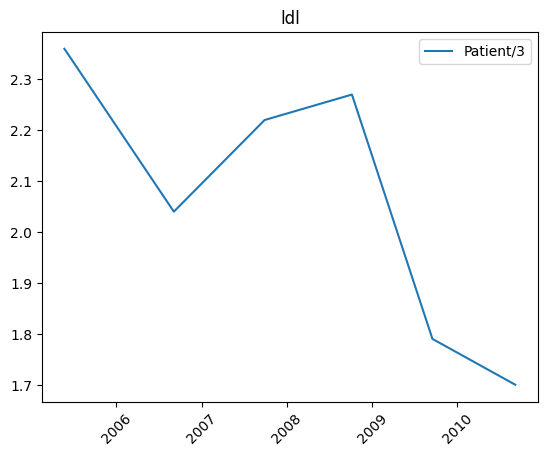

In [23]:
snomed_entry = snomed_df.loc[snomed_df['label'] == 'ldl'].iloc[0]

response = requests.get('{}/{}?patient={}&code={}'.format(BASE_URL, 'Observation', '3', snomed_entry['code']))

measures_df = pd.json_normalize(response.json(), record_path='entry')[
    ['resource.subject.reference', 'resource.effectiveDateTime', 'resource.valueQuantity.value']]
measures_df = measures_df.astype({'resource.effectiveDateTime': 'datetime64[ns]', 'resource.valueQuantity.value': 'float64'})

for patient in measures_df['resource.subject.reference'].value_counts().index:
    patient_measures_df = measures_df.loc[measures_df['resource.subject.reference'] == patient]

    plt.plot(patient_measures_df['resource.effectiveDateTime'], patient_measures_df['resource.valueQuantity.value'], label=patient)

plt.title(snomed_entry['label'])
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Get the data for patient 3

## Patient data

In [8]:
patient_id = 2

response = requests.get('{}/{}/{}'.format(BASE_URL, 'Patient', patient_id))

patient_df = pd.json_normalize(response.json())[['id', 'gender', 'birthDate']]
patient_df = patient_df.astype({'birthDate': 'datetime64[ns]'})

patient_df

,id,gender,birthDate
0,2,female,1941-07-14


## Observations

In [9]:
#Everything but treatment data
observation_codes = ','.join(snomed_df.loc[snomed_df['source'] != 'treat_data']['code'].to_list())

response = requests.get('{}/{}?patient={}&code={}'.format(BASE_URL, 'Observation', patient_id, observation_codes))

observations_df = pd.json_normalize(response.json(), record_path='entry')[
    ['resource.code.coding', 'resource.effectiveDateTime', 'resource.valueQuantity.value']]
observations_df = observations_df.astype({'resource.effectiveDateTime': 'datetime64[ns]'})
observations_df['resource.code.coding'] = observations_df['resource.code.coding'].apply(lambda code: code[0]['code'])

observations_df.rename(columns={'resource.code.coding': 'snomed', 'resource.effectiveDateTime': 'date', 
                                'resource.valueQuantity.value': 'value'}, inplace=True)

observations_df.head(10)

,snomed,date,value
0,77176002,2005-06-10,former
1,271649006,2005-05-12,148.0
2,271649006,2006-08-26,128.0
3,271649006,2007-10-13,170.0
4,271649006,2008-08-25,170.0
5,271649006,2009-08-27,150.0
6,271649006,2010-08-10,122.0
7,271650006,2005-05-12,74.0
8,271650006,2006-08-26,70.0
9,271650006,2007-10-13,70.0


## Procedures

In [10]:
#Treatment data only
proc_codes = ','.join(snomed_df.loc[snomed_df['source'] == 'treat_data']['code'].to_list())

response = requests.get('{}/{}?patient={}&code={}'.format(BASE_URL, 'Procedure', patient_id, proc_codes))

procs_df = pd.json_normalize(response.json(), record_path='entry')[
    ['resource.code.coding', 'resource.performedDateTime', 'resource.valueQuantity.value']]
procs_df = procs_df.astype({'resource.performedDateTime': 'datetime64[ns]'})
procs_df['resource.code.coding'] = procs_df['resource.code.coding'].apply(lambda code: code[0]['code'])
procs_df.rename(columns={'resource.code.coding': 'snomed', 
                         'resource.performedDateTime': 'date', 'resource.valueQuantity.value': 'value'}, inplace=True)

procs_df.head(10)

,snomed,date,value
0,271925006,2005-06-10,0.0387956197654217
1,271925006,2006-09-12,0.029311555007292
2,271925006,2007-10-15,0.0787490766132739
3,271925006,2008-09-22,0.0748521869323043
4,271925006,2009-09-21,0.0475592366499585
5,271925006,2010-08-11,0.0324986455636939
6,387458008,2005-06-10,1.0
7,387458008,2006-09-12,1.0
8,387458008,2007-10-15,1.0
9,387458008,2008-09-22,1.0


## Preprocessing

In [11]:
# Very naive preprocessing step that will normalize the data and keep only the last value for each variable
# It needs to be tailored to what you have done in Workshop 1 and ensure the variables are correctly ordered
# It is using the order from the norm_df dataframe, that is where you have dumped the normalisation for your variables
def preprocessing_step(patient_df, norm_df, observations_df, procs_df):
    data_ser = pd.Series(index=norm_df['label'].values)

    # Merging the normalisation file with the snomed codes for easier merging
    snomed_df = pd.read_csv('data/snomed.csv')
    snomed_df = snomed_df.astype({'code': 'string'})
    norm_snomed_df = norm_df.merge(snomed_df, on='label', how='outer')

    # Extracting most of the data
    data_df = pd.concat([observations_df, procs_df])

    data_df = data_df.loc[data_df['value'] != 'nan']
    
    merged_data_df = data_df.merge(norm_snomed_df, left_on=['snomed'], right_on=['code'])
    norm_data_df = merged_data_df.dropna().copy()
    norm_data_df['norm_value'] = norm_data_df.apply(lambda row: (float(row['value'])-row['mean'])/row['std'], axis=1)
    
    data_ser.update(norm_data_df[['label', 'date', 'norm_value']]\
        .sort_values(by=['label', 'date'], ascending=[True, False])\
        .drop_duplicates(subset=['label'])[['label', 'norm_value']]\
        .set_index('label')['norm_value'])
    
    # Extracting patient data
    data_ser['female'] = normalize_value(norm_snomed_df, 'female', patient_df['gender'].apply(lambda sex: 1 if sex == 'female' else 0)[0])
    data_ser['age'] = normalize_value(
        norm_snomed_df, 'age', patient_df['birthDate'].apply(lambda dob: (datetime.now() - dob).days/365.23)[0])

    # Extracting smoking data
    smoking_code = norm_snomed_df.loc[norm_snomed_df['label'] == 'smoker'].iloc[0]['code']
    smoking_status = data_df.loc[data_df['snomed'] == smoking_code].iloc[0]['value']

    # I consider only 'former' and 'current' statuses since never can be inferred from them (if they are both at 0)
    for status in ['former', 'current']:
        if smoking_status ==  status:
            value = 1
        else:
            value = 0
        
        data_ser[status] = normalize_value(norm_snomed_df, status, value)

    # Extracting diag data
    diags_df = norm_snomed_df.loc[norm_snomed_df['source'] == 'diag_data']
    
    for index, diag_info in diags_df.iterrows():
        try:
            # I try to find to get the first items in the data with the diagnosis
            # It will throw an IndexError if it cannot find it
            data_df.loc[data_df['snomed'] == diag_info['code']].iloc[0]

            value = 1
        except IndexError:
            value = 0
        data_ser[diag_info['label']] = normalize_value(norm_snomed_df, diag_info['label'], value)
    
    
    return data_ser.fillna(0)
    
def normalize_value(norm_snomed_df, variable, value):
    mean = norm_snomed_df.loc[norm_snomed_df['label'] == variable].iloc[0]['mean']
    std = norm_snomed_df.loc[norm_snomed_df['label'] == variable].iloc[0]['std']

    return (value-mean)/std

norm_df = pd.read_csv('data/normalization.csv')
data_ser = preprocessing_step(patient_df, norm_df, observations_df, procs_df)

data_ser


female          1.294774
age            -0.035613
current        -0.588366
former          1.240573
cvscore        -0.868591
aspirin         0.419849
clopridrogel   -0.203361
anticlot       -0.151878
ezetimibe      -0.136119
statins         0.410573
ace             0.515892
systolic       -1.076466
diastolic      -0.771068
erythrocytes   -1.275048
hemoglobin     -1.320485
hematocrit     -1.442950
wbc            -0.414048
platelets      -1.347499
glucose         0.033275
potassium      -0.393481
urea            0.000000
creatine        0.627767
crp             0.443390
chol           -0.479590
hdl            -0.284287
ldl            -0.455633
anxiety         0.539655
sleep          -0.144770
alcohol        -0.603405
fruit           0.523171
vegetable       0.495318
BZFC8A          1.222907
DE10           -0.457613
DE782           1.159919
dtype: float64

# Making predictions

In [12]:
import random
class FakeModel():
    def predict(self, X):
        return random.random()


model = FakeModel()

# You should be able to pass the data_ser to your model to make predictions
risk = model.predict(data_ser)

print('The risk of dying within 30 days for patient {} is {:.0%} according to my model.'.format(patient_id, risk))

The risk of dying within 30 days for patient 2 is 97% according to my model.
